# Weighted ECM clustering vs Traditional ECM clustering
## With Seeds dataset


In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from evclust.ecm import ecm
from evclust.wecm_outlier import wecm
from evclust.utils import ev_summary, ev_pcaplot, calculate_non_specificity, ev_plot_PCA, plotting
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from evclust.datasets import load_seeds


      A     B    D    E    F    G
0  15.0  15.0  6.0  3.0  2.0  5.0
1  15.0  15.0  6.0  3.0  1.0  5.0
2  14.0  14.0  5.0  3.0  3.0  5.0
3  14.0  14.0  5.0  3.0  2.0  5.0
4  16.0  15.0  6.0  4.0  1.0  5.0


D:\vtdo\projects\evclust\src\evclust\utils.py:1089: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


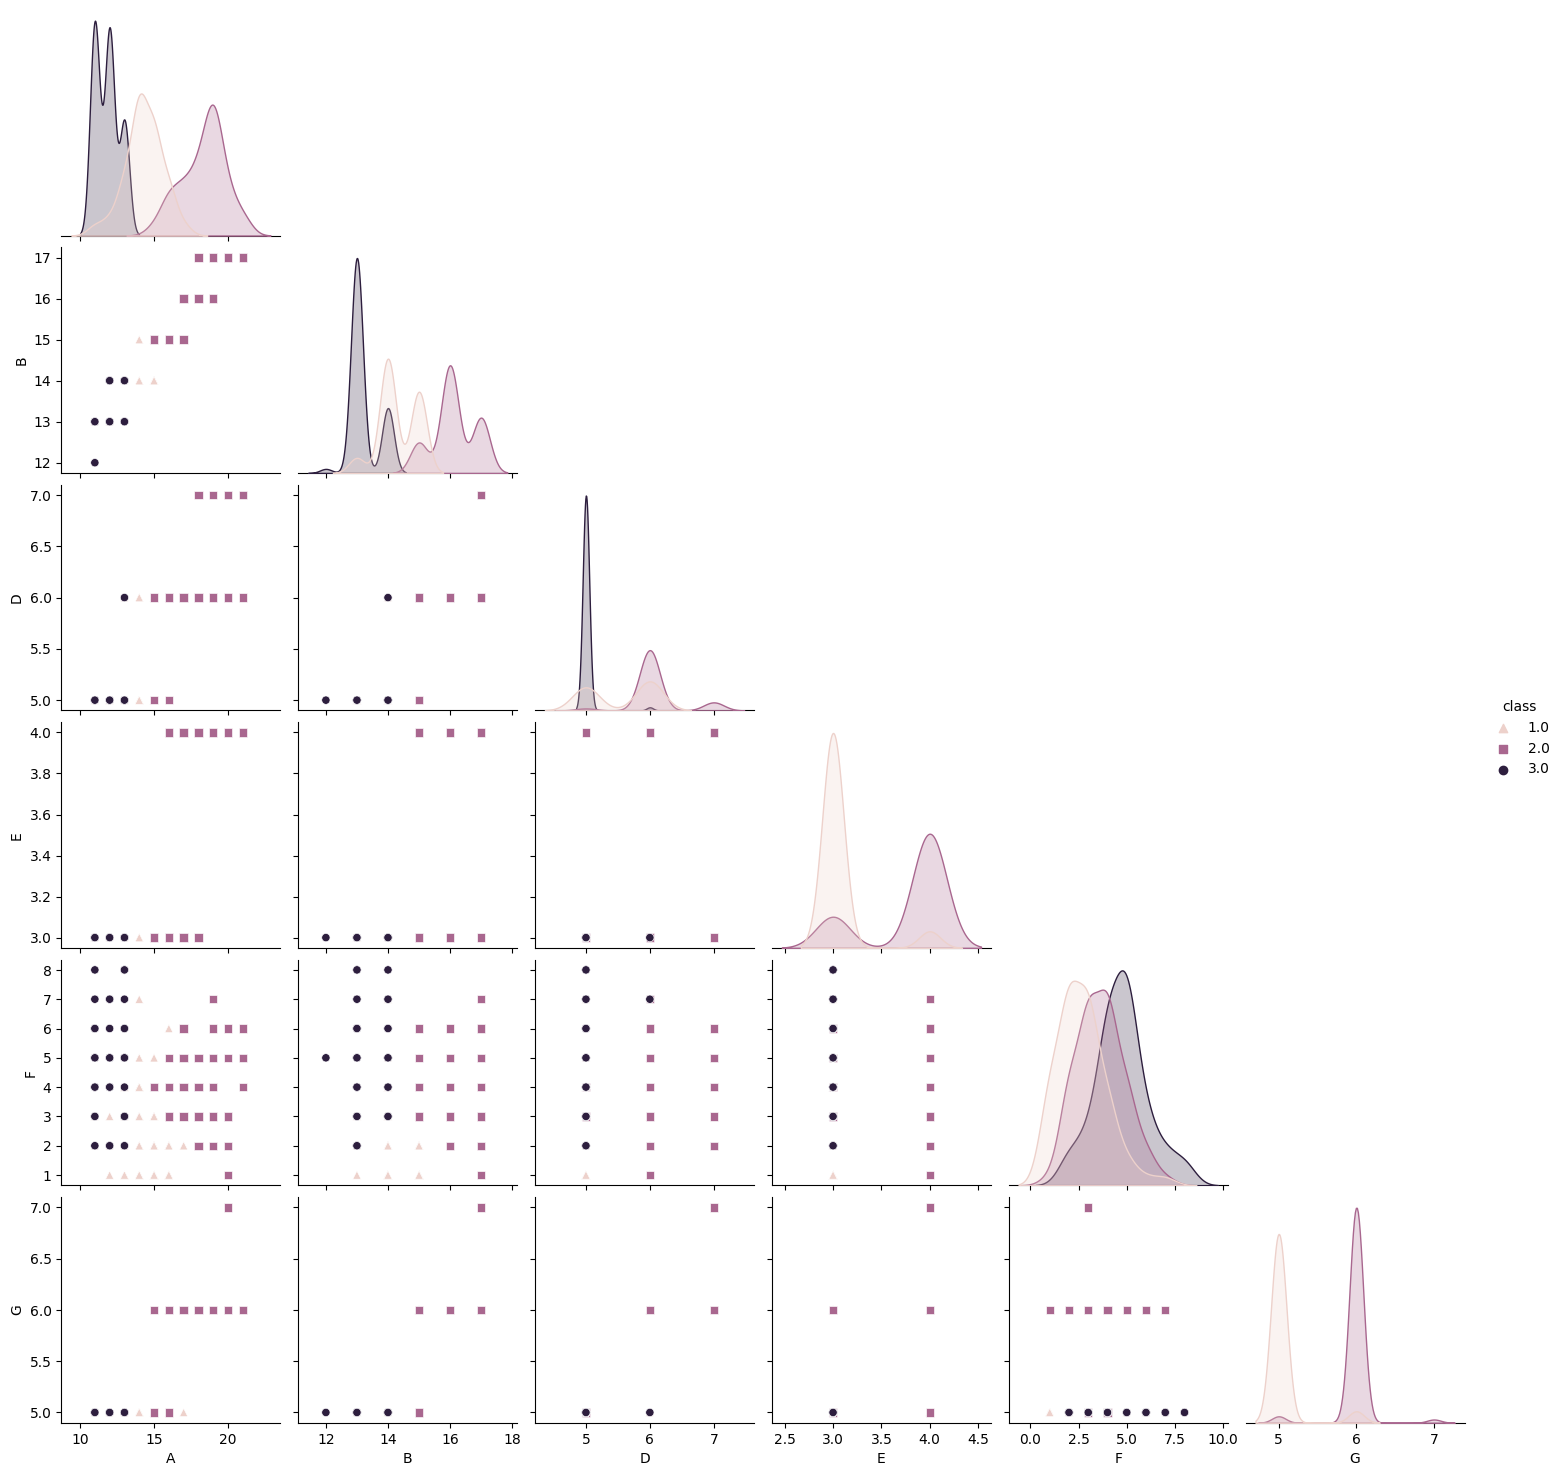

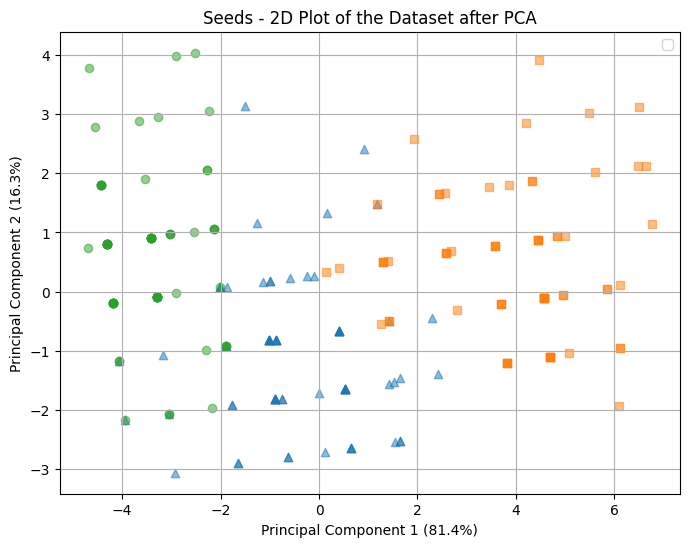

In [2]:
# fetch dataset
df = load_seeds()
df = df.drop(columns=['C'])  # all value equal 1
# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Seeds", matrix_plot=True, markers=markers)

# Normalization
# scaler = MinMaxScaler((0,1))
# X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=1, init="kmeans")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda x: x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [227.02174026132198, 227.021740261322, 227.021740261322, 227.021740261322, 227.021740261322, 227.021740261322, 227.02174026132204, 227.02174026132204, 227.02174026132204, 227.02174026132204]
ARI values: [0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478, 0.6971845096584478]
NS values: [1.2284391233730136, 1.2053630380178413, 1.2053630380178413, 1.2053630380178413, 1.2520287646394754, 1.2053630380178413, 1.1772178051058464, 1.2516849425565029, 1.2516849425565029, 1.1772178051058464]
NMI values: [0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385, 0.6553927643447385]
Average ARI values: 0.6971845096584478
Average Non-specificity: 1.2159725535408552
Average Normalized mutual infor: 0.6553927643447385


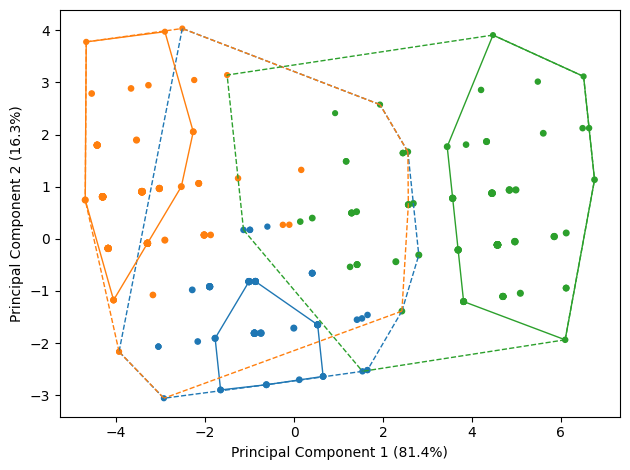

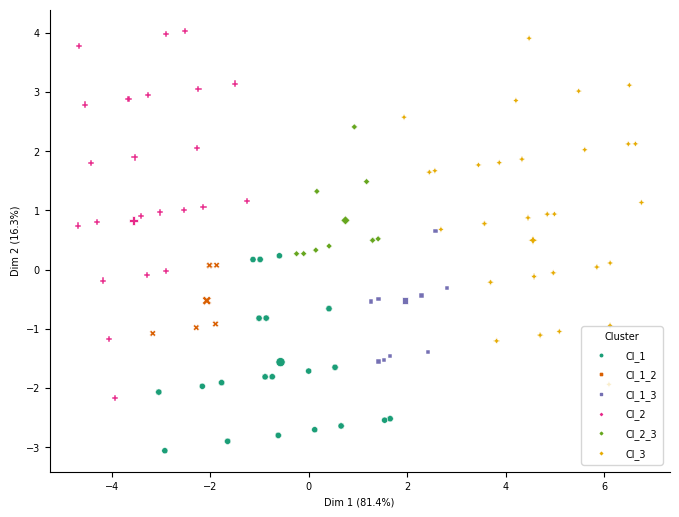

In [4]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting the model with the minimum J value
ev_plot_PCA(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (W ECM)

In [5]:
%%capture
model_list = np.array([])
c = 3
d = X.shape[1]
delta = np.sqrt(20)
for i in range(10):
    W = np.ones((c, d)) * (1 / d)
    model = wecm(x=X, c=c, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=1, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda model: model['crit'])
# Weights
top_weights = [model['W'] for model in model_list]

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

In [6]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

J values: [0.2953914911256651, 0.2953914911256651, 0.2953914911256651, 0.29539149112566515, 0.2953914911256653, 0.2953914911256653, 0.2953914911256653, 0.2953914911256653, 0.2953914911256653, 0.2953914911256653]
ARI values: [0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225, 0.45136200581034225]
NS values: [0.7634836363229707, 0.5468632899690609, 0.7634836363229707, 0.7954176268954151, 0.7627256732751555, 0.7627256732751555, 0.7627256732751555, 0.7995089781481883, 0.7995089781481883, 0.7995089781481883]
NMI values: [0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068, 0.4792759439301068]
Average ARI values: 0.4513620058103422
Average Non-specificity: 0.7555952143780449
Average Normalized mutual infor: 0.47927594393010675


In [7]:
for W in top_weights:
    print(f"\n{W}")


[[ 2.08908723e-03  8.51945547e-03  1.52599524e-02  5.21500723e-01
   1.48390296e-03  4.51146879e-01]
 [ 6.88735437e-04  2.63584296e-03  2.47790249e-01  4.13814983e-01
  -4.18380309e-05  3.35112028e-01]
 [ 1.45697897e-03  4.86506911e-03  4.43756152e-01  5.47474184e-01
   8.45723499e-04  1.60189183e-03]]

[[ 6.88735437e-04  2.63584296e-03  2.47790249e-01  4.13814983e-01
  -4.18380309e-05  3.35112028e-01]
 [ 1.45697897e-03  4.86506911e-03  4.43756152e-01  5.47474184e-01
   8.45723499e-04  1.60189183e-03]
 [ 2.08908723e-03  8.51945547e-03  1.52599524e-02  5.21500723e-01
   1.48390296e-03  4.51146879e-01]]

[[ 2.08908723e-03  8.51945547e-03  1.52599524e-02  5.21500723e-01
   1.48390296e-03  4.51146879e-01]
 [ 6.88735437e-04  2.63584296e-03  2.47790249e-01  4.13814983e-01
  -4.18380309e-05  3.35112028e-01]
 [ 1.45697897e-03  4.86506911e-03  4.43756152e-01  5.47474184e-01
   8.45723499e-04  1.60189183e-03]]

[[ 1.45697897e-03  4.86506911e-03  4.43756152e-01  5.47474184e-01
   8.45723499e-04 